In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import Dataset,DataLoader
import numpy as np

In [13]:
#读取数据切割数据集并保存
TRAIN_WEIGHT=0.9
SEQ_LEN=99
LEARNING_RATE=0.00001
BATCH_SIZE=16
#train_size=int(TRAIN_WEIGHT*(data.shape[0]))
train_path="stock_daily/stock_train.csv"
test_path="stock_daily/stock_test.csv"
#Train_data=data[:train_size+SEQ_LEN]
#Test_data=data[train_size-SEQ_LEN:]
#Train_data.to_csv(train_path,sep=',',index=False,header=False)
#Test_data.to_csv(test_path,sep=',',index=False,header=False)

In [14]:
mean_list=[]
std_list=[]

In [15]:
#完成数据集类
class Stock_Data(Dataset):
    def __init__(self,train=True,transform=None):        
        if train==True:
            train_path="stock_daily/stock_train.csv"
            with open(train_path) as f:
                self.data = np.loadtxt(f,delimiter = ",")
                #可以注释
                #addi=np.zeros((self.data.shape[0],1))
                #self.data=np.concatenate((self.data,addi),axis=1)
                self.data=self.data[:,0:8]
            for i in range(len(self.data[0])):
                mean_list.append(np.mean(self.data[:,i]))
                std_list.append(np.std(self.data[:,i]))
                self.data[:,i]=(self.data[:,i]-np.mean(self.data[:,i]))/(np.std(self.data[:,i])+1e-8)
            self.value=torch.rand(self.data.shape[0]-SEQ_LEN,SEQ_LEN,self.data.shape[1])
            self.label=torch.rand(self.data.shape[0]-SEQ_LEN,1)
            for i in range(self.data.shape[0]-SEQ_LEN):                  
                self.value[i,:,:]=torch.from_numpy(self.data[i:i+SEQ_LEN,:].reshape(SEQ_LEN,self.data.shape[1]))    
                self.label[i,:]=self.data[i+SEQ_LEN,0]
            self.data=self.value
        else:
            test_path="stock_daily/stock_test.csv"
            with open(test_path) as f:
                self.data = np.loadtxt(f,delimiter = ",")
                #addi=np.zeros((self.data.shape[0],1))
                #self.data=np.concatenate((self.data,addi),axis=1)
                self.data=self.data[:,0:8]
            for i in range(len(self.data[0])):
                self.data[:,i]=(self.data[:,i]-mean_list[i])/(std_list[i]+1e-8)
            self.value=torch.rand(self.data.shape[0]-SEQ_LEN,SEQ_LEN,self.data.shape[1])
            self.label=torch.rand(self.data.shape[0]-SEQ_LEN,1)
            for i in range(self.data.shape[0]-SEQ_LEN):                  
                self.value[i,:,:]=torch.from_numpy(self.data[i:i+SEQ_LEN,:].reshape(SEQ_LEN,self.data.shape[1]))    
                self.label[i,:]=self.data[i+SEQ_LEN,0]
            self.data=self.value
    def __getitem__(self,index):
        return self.data[index],self.label[index]
    def __len__(self):
        return len(self.data[:,0])

In [16]:
stock_train=Stock_Data(train=True)
stock_test=Stock_Data(train=False)

In [17]:
class LSTM(nn.Module):
    def __init__(self,dimension):
        super(LSTM,self).__init__()
        self.lstm=nn.LSTM(input_size=dimension,hidden_size=128,num_layers=3,batch_first=True)
        self.linear1=nn.Linear(in_features=128,out_features=16)
        self.linear2=nn.Linear(16,1)
    def forward(self,x):
        out,_=self.lstm(x)
        x=out[:,-1,:]        
        x=self.linear1(x)
        x=self.linear2(x)
        return x

In [18]:
def train(epoch):    
    model.train()
    global loss_list
    global iteration
    dataloader=DataLoader(dataset=stock_train,batch_size=BATCH_SIZE,shuffle=False,drop_last=True)
    for i,(data,label) in enumerate(dataloader):
        iteration=iteration+1
        data,label = data.to(device),label.to(device)
        optimizer.zero_grad()
        output=model.forward(data)
        loss=criterion(output,label)
        loss.backward()        
        optimizer.step()
        if i%20==0:
            loss_list.append(loss.item())
            print("epoch=",epoch,"iteration=",iteration,"loss=",loss.item())

In [19]:
def test():
    model.eval()
    global accuracy_list
    global predict_list
    dataloader=DataLoader(dataset=stock_test,batch_size=BATCH_SIZE,shuffle=False,drop_last=True)
    for i,(data,label) in enumerate(dataloader):
        with torch.no_grad():            
            data,label=data.to(device),label.to(device)
            optimizer.zero_grad()
            predict=model.forward(data)
            predict_list.append(predict)
            loss=criterion(predict,label)
            accuracy_fn=nn.MSELoss()
            accuracy=accuracy_fn(predict,label)
            accuracy_list.append(accuracy.item())
    print("test_data MSELoss:(pred-real)/real=",np.mean(accuracy_list))

In [20]:
def loss_curve(loss_list):
    x=np.linspace(1,len(loss_list),len(loss_list))
    x=20*x
    plt.plot(x,np.array(loss_list),label="train_loss")
    plt.ylabel("MSELoss")
    plt.xlabel("iteration")
    plt.savefig("train_loss.png",dpi=3000)
    plt.show()

In [21]:
def contrast_lines(predict_list):
    real_list=[]
    prediction_list=[]
    dataloader=DataLoader(dataset=stock_test,batch_size=BATCH_SIZE,shuffle=False,drop_last=True)
    for i,(data,label) in enumerate(dataloader):
        for idx in range(BATCH_SIZE):
            real_list.append(np.array(label[idx]*std_list[0]+mean_list[0]))
    for item in predict_list:
        item=item.to("cpu")
        for idx in range(BATCH_SIZE):
            prediction_list.append(np.array((item[idx]*std_list[0]+mean_list[0])))
    x=np.linspace(1,len(real_list),len(real_list))
    plt.plot(x,np.array(real_list),label="real")
    plt.plot(x,np.array(prediction_list),label="prediction")
    plt.legend()
    plt.savefig("600519_Pre.png",dpi=3000)
    plt.show()

In [22]:
#x维度实例化模型
model=LSTM(dimension=8)
model=model.to(device)
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=LEARNING_RATE)

epoch= 0 iteration= 1 loss= 1.4240838289260864
epoch= 0 iteration= 21 loss= 0.5112948417663574
epoch= 0 iteration= 41 loss= 0.23975816369056702
epoch= 0 iteration= 61 loss= 0.3257552683353424
epoch= 0 iteration= 81 loss= 1.496315836906433
test_data MSELoss:(pred-real)/real= 1.5008195373747084
epoch= 1 iteration= 94 loss= 1.3976850509643555
epoch= 1 iteration= 114 loss= 0.5045064091682434
epoch= 1 iteration= 134 loss= 0.2371928095817566
epoch= 1 iteration= 154 loss= 0.3159105181694031
epoch= 1 iteration= 174 loss= 1.465603232383728
test_data MSELoss:(pred-real)/real= 1.4607597721947565
epoch= 2 iteration= 187 loss= 1.3742033243179321
epoch= 2 iteration= 207 loss= 0.4931754767894745
epoch= 2 iteration= 227 loss= 0.23092830181121826
epoch= 2 iteration= 247 loss= 0.30507445335388184
epoch= 2 iteration= 267 loss= 1.421673059463501
test_data MSELoss:(pred-real)/real= 1.3984482619497511
epoch= 3 iteration= 280 loss= 1.331024408340454
epoch= 3 iteration= 300 loss= 0.47058483958244324
epoch= 3 

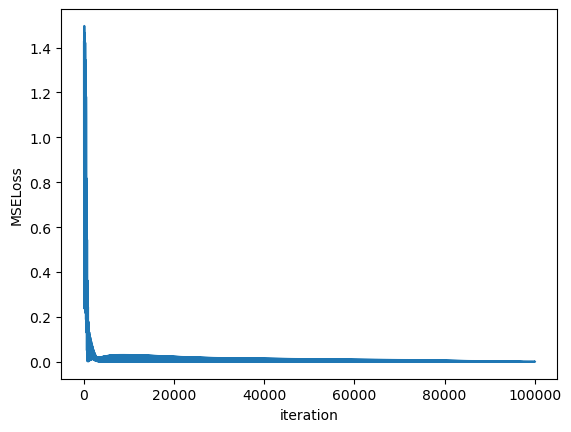

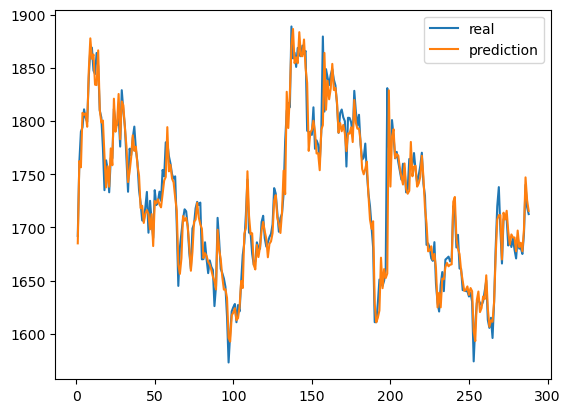

In [23]:
if __name__=="__main__":   
    period = 100  
    iteration=0
    loss_list=[]
    #开始训练神经网络
    for epoch in range(1000):         
        predict_list=[]
        accuracy_list=[]
        train(epoch)
        test()
    #绘制损失函数下降曲线    
    loss_curve(loss_list)
    #绘制测试集pred-real对比曲线
    contrast_lines(predict_list)